# 1. | Introduction

### 1.1 | Intro

The Hungarian capital, Budapest's growing, nearly 2 million population require an extensive public transport network. This paper aim to analyse the operation of Budapest public transport by exploring the openly accessible GTFS data format. The analysis will further investigate the public bus routes as a key part of the urban transportation mix. Discovering key similarities among bus routes will help identify clusters of bus services with different characteristics across the city. Better understanding of the bus network will lead to more sufficient, data-led city planning such as reduce congestions, create more efficient schedule, discover bus lane need, or improve air quality. 

Budapest and most cities transportation need significantly differ based on whether it’s a weekday or weekend. Therefore, paper will differentiate between a regular weekday’s and weekend’s transportation schedule to provide comparison between the two contrasting operation mode. 

### 1.2 | Technical Requirements

For the analysis, the following python libraries will be used. The aim was to use standard libraries to showcase how regular pandas and geopandas can be sufficient to work with GTFS format. For the clustering, Sklearn machine learning library is imported. To create the data visualisations Seaborn, Contextily and Folium packages are selected. For the analysis, the following Python libraries will be used. The aim was to use standard libraries to showcase how regular Pandas and Geopandas can be sufficient to work with GTFS format. For the clustering, Sklearn machine learning library is imported. To create the data visualisations Seaborn, Contextily and Folium packages are utilised. 

In [1]:
## Libraries for data processing
import pandas as pd
import numpy as np

## Machine learning library - Kmeans
from sklearn.cluster import KMeans
## Rescalers to standardise numeric data attributes
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))
minmax = MinMaxScaler()

## general visualisation library
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## For geospatial visualisation 

import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point, LineString
import folium
from folium.plugins import HeatMap, HeatMapWithTime

# 2. | Literature review

Public transportation is a key component of urban development and planning. In most major cities, significant public spending is allocated towards enhancing transportation networks, as they impact the socio-economic development of areas, through providing (or limiting) access to education, employment, healthcare and leisure (Deka, D., 2004). Access to various forms of transportation has long been seen as a source of economic inequality – owning a horse in the middle ages meant you could get further than simply on foot. Today, numerous studies suggest that lower income households are drawn towards the more impoverished, inner-city areas due to cheaper access to transportation than in the suburbs (LeRoy and Sonstelie, 1983; Glaeser et al., 2008). 
In addition, transportation networks can have substantial environmental impacts. As the global rate of automobiles per capita continues to rise, countries and particularly large cities can expect a continued rise in traffic congestions and related pollution (via emissions) unless significant action is taken (May, 2013). As such, enhancements opportunities in urban transportation planning are highly sought-after, particularly in the developed world, where countries have means for funding such projects. 

There are various modes of transport that define a particular cities urban transportation structure. In most cities cars and public busses tend to be the primary form of transportation, however many cities have popular alternatives, such as the underground in London (Guo and Wilson, 2011), or cycling network in Amsterdam (Buehler and Pucher, 2009). For Budapest in particular, the public transportation mix is fairly complex, with numerous metro lines, buses, trams, trolleybuses, and overground systems collectively operating to sustain the population’s transportation needs. The following essay will focus on the 229 bus services with 710 routes across Budapest and their characteristics. 

This analysis will only use GTFS feed data. GTFS is becoming more and more accessible across the world. The larges data store can be found on transitfeeds.com, with currently 677 location’s GTFS feed provided by 1327 provider. Analysing and understanding these feeds lead to better understand the transit of cities and can provide improvement opportunities

Research Questions:

R1: What are the key components of Budapest’s public transportation mix?

R2: How can we categories Budapest public bus route system based on key variables?


# 3. | Methodology

The accessed GTFS data contains an entire month (November 2020) of public transport schedule. This dataset was selected for the purpose of excluding Covid-19 related anomalies in the transportation schedule. According to the operator company the schedule is defined monthly, therefore generally the same day of the weeks has essentially the same routes and timetable planned for. For memory efficiency reasons, the busiest weekend (Saturday or Sunday) and the busiest weekday (Monday, Tuesday, Wednesday, Thursday, Friday) in the month will be selected as samples for the analysis and clustering. 
This workpaper will provided step-by-step instructions from reading the raw data, cleaning and preparing it to the explanatory analysis and bus route clustering. The explanatory analysis will be aimed to showcase the information that can be gathered from the rich GTFS file format. Apart from highlight the general usefulness of the GTFS public transport data, we wish to gain more understanding of Budapest public transportation system. The workpaper also written with the aim of reusability whether using another month of Budapest GTFS data or use a different cities GTFS dataset.  
This analysis will be using GTFS (General Transit Feed Specification) Static and not the real-time extensions of GTFS.  GTFS contains multiple txt files which has complex relational relationships. In the case of BKK it contains the following files:
-	agency.txt – It contains information about the service agency (BKK) of the feed, and time zone of the city where the transit operates and contact information.
-	stops.txt –It contains the transit station/stop names, stop ID, and geo-locations (latitude, longitude).
-	 trips.txt –It contains the directions headed of each vehicle movement. Each trip has a service ID which specifies the days it operates on.
-	route.txt –It contains the information on how trips are grouped into single services. Vehicle type of transportation, name/number of the route, 
-	stop_times.txt –It contains the information on the arrival and departure time of each transit station/stop, as well as station sequence and corresponding trip IDs. This is the largest file in the folder
-	calendar_dates.txt –It contains the service id and their related dates
-	 shapes.txt –It contains geographical polylines representing the routes that a transit vehicle takes. 

(Kunama et al., 2017)


The relationship among the tables is illustrated below. 

[IMAGE]


(Modified from source: Prommaharaj et al., 2020)

In order to execute the clustering of bus routes, K-means classification method will be utilised. K-means is an unsupervised machine learning algorithm, therefore by definition it seeks to uncover hidden characteristics of the data feed into it. (Allahyari et al., 2017). No training dataset required, and the algorithm can be used on numerical and categorical data attributes. The following numerical attribute will be calculated in order to create the clusters:
1.	Average speed of the route/shape – defined in km/h
2.	Stop Density of route/shape - stops per kilometre across the route
3.	Trip activity level - number of trips have been taken on the route in a day

For defining the K – number of clusters for our classifications, we’ll be using the Elbow Method. Elbow Method is a popular test to conduct to identify the appropriate number of clusters that the data requires. 


# 4. Data Processing

### 4.1 | Data Gathering

The raw GTFS data has been provided by Budapesti Kozlekedes Kozpont (BKK). The GTFS files are being published montly on BKK's For Developers page (https://bkk.hu/fejlesztesek/fejlesztoknek/). For this analysis, I use one months of GTFS feed from the 1st of November to the 1st of December 2020. The GTFS data has been downloaded, extracted and uploaded to AWS S3 for convinient accessibility.
 
Each necessecery txt file has been read into a Pandas dataframe. It's important to make sure we use low memory settings, because 

In [2]:
path = 'https://budapest-dsss-data.s3.eu-west-2.amazonaws.com/BKK_budapest_gtfs'

routes = pd.read_csv(path + "/routes.txt", delimiter=",", low_memory=True)
stops = pd.read_csv(path + "/stops.txt", delimiter=",", low_memory=True)
stop_times = pd.read_csv(path + "/stop_times.txt", delimiter=",", low_memory=True, usecols=['trip_id', 'stop_id', 'arrival_time', 'departure_time','stop_sequence', 'shape_dist_traveled'])
trips = pd.read_csv(path + "/trips.txt", delimiter=",", low_memory=True, usecols=['route_id', 'trip_id', 'service_id', 'trip_headsign', 'direction_id','block_id', 'shape_id'])
shapes = pd.read_csv(path + "/shapes.txt", delimiter=",", low_memory=True)
calendar_dates = pd.read_csv(path + "/calendar_dates.txt", delimiter=",", low_memory=True)

### 4.2 | Data Cleaning, Preparation

First, select the busiest week day and the busiest weekend for example

I merged the calendar_dates and certain attributes from the routes dataframe with the trips dataframe. Additionaly, I delete the calendar_dates and routes dataframe to save memory usage.

In [3]:
calendar_dates['weekend']  = pd.to_datetime(calendar_dates['date'], format='%Y%m%d').dt.weekday
calendar_dates.loc[:,'weekend']  = calendar_dates.weekend >= 5

In [4]:
calendar_dates.groupby(['date','weekend']).agg({'service_id' : 'count'}).sort_values("service_id", ascending=False)

service_id
date     weekend            
20201116 False           250
20201111 False           250
20201119 False           250
20201118 False           250
20201117 False           250
20201124 False           250
20201125 False           250
20201126 False           250
20201112 False           250
20201110 False           250
20201130 False           250
20201123 False           249
20201109 False           249
20201127 False           249
20201113 False           249
20201106 False           249
20201120 False           249
20201105 False           248
20201104 False           248
20201103 False           248
20201102 False           248
20201201 False           243
20201031 True            215
20201121 True            212
20201114 True            212
20201128 True            212
20201107 True            212
20201101 True            208
20201129 True            207
20201122 True            206
20201115 True            206
20201108 True            206

Filter for the busiest weekday and weekend day selected from the list above.

**Weekday**: 16. 11. 2020

**Weekend**: 31. 10. 2020

In [5]:
## Filter to busiest weekday + weekend day
calendar_dates = calendar_dates[(calendar_dates.date==20201116) | (calendar_dates.date==20201031)]

In [6]:
### Add dates
trips  =pd.merge(trips, calendar_dates, on="service_id", how='inner') 
### Add route type and more to trips
trips = pd.merge(trips, routes[['route_id','route_short_name', 'route_type']], how='left', on="route_id")

del calendar_dates
del routes

In [7]:
stop_times = pd.merge(stop_times, trips, on="trip_id", how='inner') 

In [8]:
print('Total number of stops during the selected two days: ' + str(len(stop_times)))

Total number of stops during the selected two days: 1435115


#### Stop departure and arrivial times tranformation to date format

To optimise data handling, I transform the arrival and departure time columns from stop_times dataframe to proper datatime format. Where the value cannot be trasform, I drop those entries to ensure data cleanlinese. 

Fix arrival time, everyting above 24h must be transformed

In [9]:
stop_times['arrival_h'] = stop_times.arrival_time.apply(lambda x : int(x.split(":")[0]))
#stop_times['departure_h'] = stop_times.departure_time.apply(lambda x : int(x.split(":")[0]))

stop_times['fix_datetime_arrival_time']  = stop_times.arrival_h.apply(lambda x :  True if x >=24 else False)
stop_times['arrival_h']  = stop_times.arrival_h.apply(lambda x :  x - 24 if x >=24 else x)

In [10]:
stop_times['arrival_time'] = stop_times['arrival_h'].map("{:02}".format) + stop_times['arrival_time'].apply(lambda x : x[2:])

In [11]:
stop_times.arrival_time = pd.to_datetime( stop_times.arrival_time, format= '%H:%M:%S', errors='coerce')
stop_times.dropna(subset=["arrival_time"], inplace=True)

<AxesSubplot:xlabel='arrival_time'>

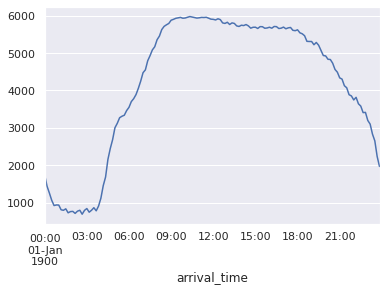

In [12]:
### Check stops in every 10 mins activity on the weekend
stop_times[stop_times.weekend].resample('10T', on='arrival_time').stop_id.count().plot.line()


<AxesSubplot:xlabel='arrival_time'>

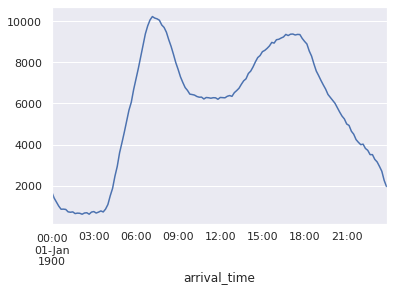

In [13]:
## None Weekend
stop_times[~stop_times.weekend].resample('10T', on='arrival_time').stop_id.count().plot.line()

#### Transform Date
define and separate weekdays and weekend days

In [14]:
## define which data is weekend
stop_times['date'] = pd.to_datetime(stop_times['date'], format='%Y%m%d')

In [15]:
stop_times.loc[stop_times.fix_datetime_arrival_time, 'date'] = stop_times[stop_times.fix_datetime_arrival_time]['date'] - pd.Timedelta(days=1)

In [16]:
stop_times.weekend.value_counts()

False    829191
True     605924
Name: weekend, dtype: int64

### Calcualte data attributes of individual trips for clustering excersise

##### These attrributes are the following:
- Average Speed of the trip
- Stop Density of the trip, i.e. stops per kilometer
- Trip activity level, - average of number of times the trips taken in a day

In [17]:
stats_week_weekend  = stop_times.groupby(['trip_id', 'weekend']).agg({'arrival_time' : ['first', 'last'], 'shape_dist_traveled' : 'max', 'stop_sequence' : 'max', 'stop_id' : 'count' })

In [18]:
stats_week_weekend.columns = [' '.join(col).strip() for col in stats_week_weekend.columns.values]
stats_week_weekend.rename(columns={'arrival_time first' : 'departure_time' , 'arrival_time last' : 'arrival_time', 'shape_dist_traveled max' : 'shape_dist_traveled', 'stop_sequence max' : 'stop_sequence', 'stop_id count' : 'stop_id' }, inplace=True)
stats_week_weekend.head(2)

departure_time        arrival_time  \
trip_id   weekend                                           
B4709610  False   1900-01-01 07:01:15 1900-01-01 07:13:35   
B47096100 False   1900-01-01 23:35:25 1900-01-01 23:47:40   

                   shape_dist_traveled  stop_sequence  stop_id  
trip_id   weekend                                               
B4709610  False                 4278.0             10       11  
B47096100 False                 4278.0             10       11

In [19]:
## define which data is weekend

In [20]:
stats_week_weekend['duration'] = stats_week_weekend.arrival_time - stats_week_weekend.departure_time
stats_week_weekend['duration'] = stats_week_weekend['duration'].dt.total_seconds() / 60 / 60
stats_week_weekend['speed'] = stats_week_weekend.shape_dist_traveled /1000 / stats_week_weekend['duration']

stats_week_weekend.speed.replace([np.inf, -np.inf], np.nan)
stats_week_weekend.dropna(subset=['speed'], inplace=True, how="all")

stats_week_weekend = stats_week_weekend[stats_week_weekend.speed!=np.inf]

In [21]:
## Stop density: how many stop the route/trip has per 1km
stats_week_weekend['stop_density'] =stats_week_weekend['stop_sequence'] / stats_week_weekend['shape_dist_traveled'] * 1000

In [22]:
## Shape stats created - 
shape_stats_week_weekend = pd.merge(trips.drop(columns=['weekend']), stats_week_weekend.reset_index(), how="inner", on="trip_id").groupby(["shape_id", 'weekend']).agg({'trip_id' : 'count', 'service_id' : 'first' ,"duration" : "mean" , 'speed' : "mean",'stop_density': 'mean', "stop_sequence" : "mean", 'route_short_name' :'first', 'route_type':'first' })

In [23]:
## trip_id = trip taken during the months period (no. vehicule on the route)
## stop_sequence = no. stop in the route
## arrival_time = avg waiting time on the route
shape_stats_week_weekend.rename(columns={ 'trip_id' : 'count_trips', 'stop_sequence' : 'count_stops'}, inplace=True)
shape_stats_week_weekend.to_csv('./output/shape_stats_week_weekend.csv')

In [24]:
shape_stats_week_weekend.reset_index(inplace=True)

### Cleaning unrealistic Outliers

<AxesSubplot:ylabel='Frequency'>

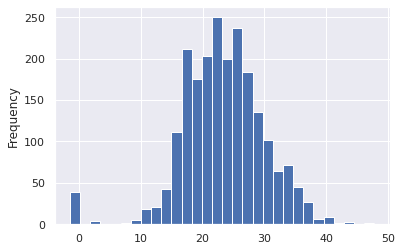

In [25]:
shape_stats_week_weekend.speed.plot.hist(bins=30)

In [26]:
## Drop the routes with less than 0 km/h avg speed 

In [28]:
shape_stats_week_weekend.drop(axis=1, index=shape_stats_week_weekend[shape_stats_week_weekend.speed < 3].index,inplace=True)

<AxesSubplot:ylabel='Frequency'>

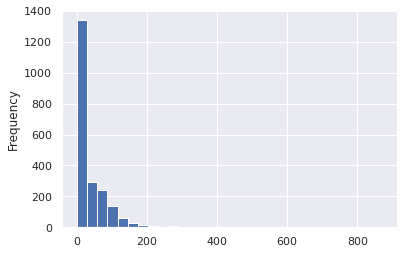

In [29]:
shape_stats_week_weekend.count_trips.plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

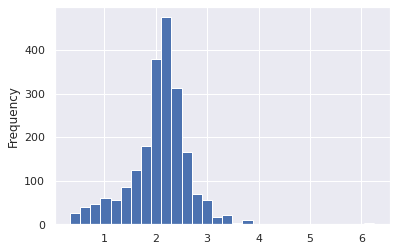

In [36]:
shape_stats_week_weekend.stop_density.plot.hist(bins=30)

### Transform the two calcualted dataframe to geopandas dataframe

In [37]:
### Transform to Geopandas
shapes['geometry'] = shapes.apply(lambda x : (x.shape_pt_lon, x.shape_pt_lat), axis=1)
gdf_shapes= gpd.GeoDataFrame(pd.DataFrame(shapes.groupby('shape_id').agg({ 'shape_dist_traveled' : 'max' ,'geometry' : lambda x : LineString(list(x))})), geometry='geometry', crs='epsg:4326')
gdf_shapes_weekend = pd.merge(gdf_shapes, shape_stats_week_weekend[shape_stats_week_weekend.weekend], how="inner", on="shape_id")
gdf_shapes_week = pd.merge(gdf_shapes, shape_stats_week_weekend[~shape_stats_week_weekend.weekend], how="inner", on="shape_id")

# 5. Analysis

### 5.1 Descriptive Stats

#### 5.1.1 Visualise the vehicule types 

In the dataset provided the following codes represent the different public transport types:
- 0 - Tram
- 1 - Tube
- 3 - Bus
- 4 - Boat
- 109 - Overground
- 800 - Trolleybus

In [38]:
vehicle_types = {0 : "Tram", 1 : "Tube", 3 :  "Bus" , 4 : "Boat", 109 : "Overground" , 800 : "Trolleybus"}
colors = {"Tram" : "#FFD800","Tube" :  "#8702d4", "Bus" : "#009FE3", "Boat" : "#02f6fa", "Overground" : "#02a823", "Trolleybus":"#FF1609" }

gdf_shapes_weekend.route_type = gdf_shapes_weekend.route_type.apply(lambda x : vehicle_types[x]).copy()
gdf_shapes_week.route_type = gdf_shapes_week.route_type.apply(lambda x : vehicle_types[x]).copy()

gdf_shapes_weekend["route_color"] = gdf_shapes_weekend.route_type.apply(lambda x : colors[x]).copy()
gdf_shapes_week["route_color"] = gdf_shapes_week.route_type.apply(lambda x : colors[x]).copy()

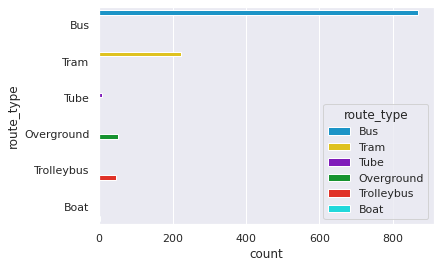

In [39]:
## No. routes by vehicule category - weekday
ax = sns.countplot(y="route_type", data=gdf_shapes_week, hue='route_type', palette=colors)

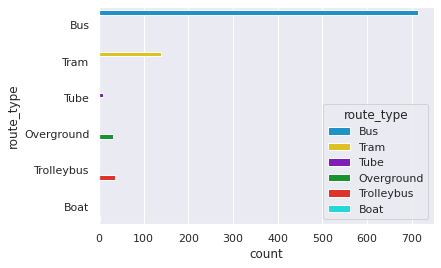

In [40]:
## No. routes by vehicule category - Weekend
ax = sns.countplot(y="route_type", data=gdf_shapes_weekend, hue='route_type', palette=colors )

[]

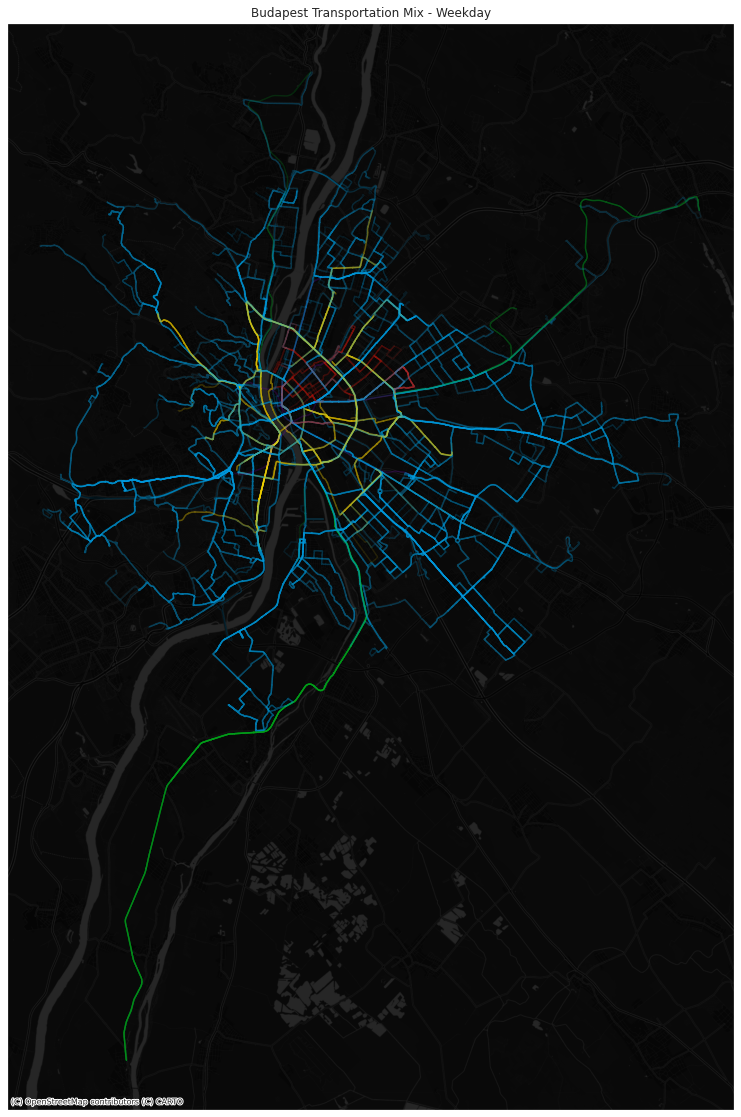

In [41]:
gdf_shapes_week = gdf_shapes_week.to_crs(epsg=3857)
ax = gdf_shapes_week.plot(figsize=(20, 20), alpha=0.1, color=gdf_shapes_week['route_color'])
ctx.add_basemap(ax, zoom=12, source=ctx.providers.CartoDB.DarkMatterNoLabels)
ax.grid(False)
ax.set_xticks([])
ax.set_title("Budapest Transportation Mix - Weekday")
ax.set_yticks([])


[]

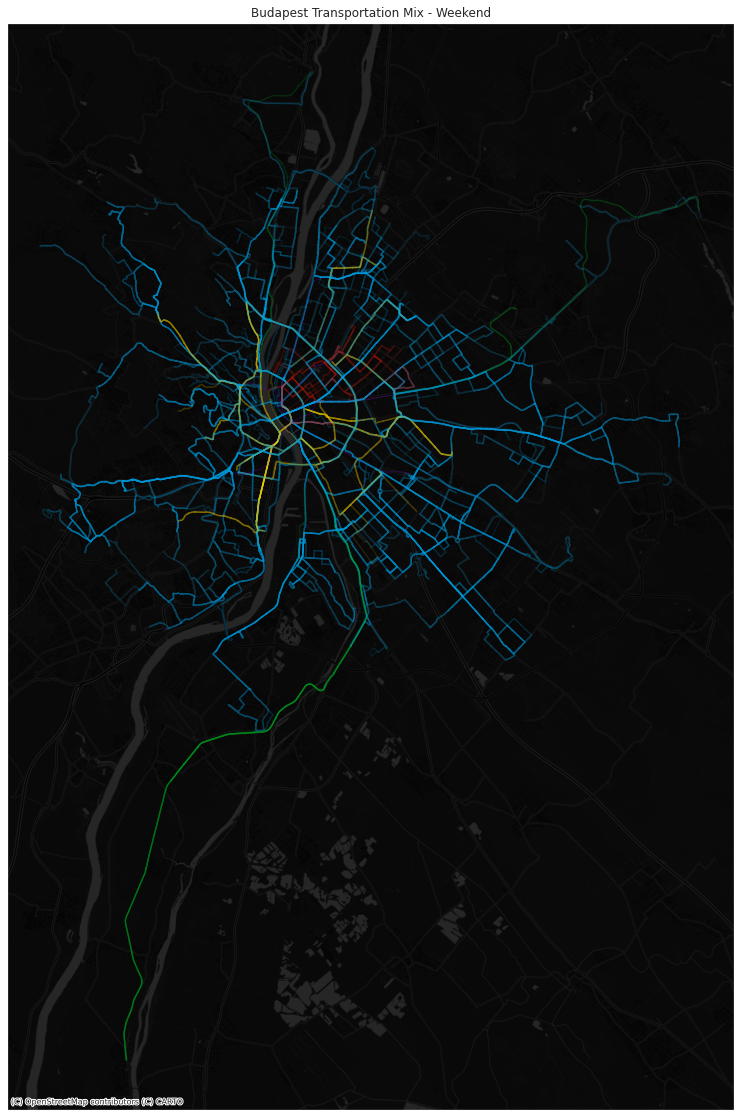

In [42]:
gdf_shapes_weekend = gdf_shapes_weekend.to_crs(epsg=3857)
ax = gdf_shapes_weekend.plot(figsize=(20, 20), alpha=0.1, color=gdf_shapes_weekend['route_color'] )
ctx.add_basemap(ax, zoom=12, source=ctx.providers.CartoDB.DarkMatterNoLabels)
ax.grid(False)
ax.set_xticks([])
ax.set_title("Budapest Transportation Mix - Weekend")
ax.set_yticks([])

#### 5.1.2 Visualise trafic of stops

To visualise the bus stops on the map we need to transform the Pandas Dataframe to Geopandas Dataframe:

In [43]:
stops = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(stops.stop_lon,stops.stop_lat, crs='epsg:4326'))

In [44]:
print('Total number of stops: ' + str(len(stops)))

Total number of stops: 5903


[]

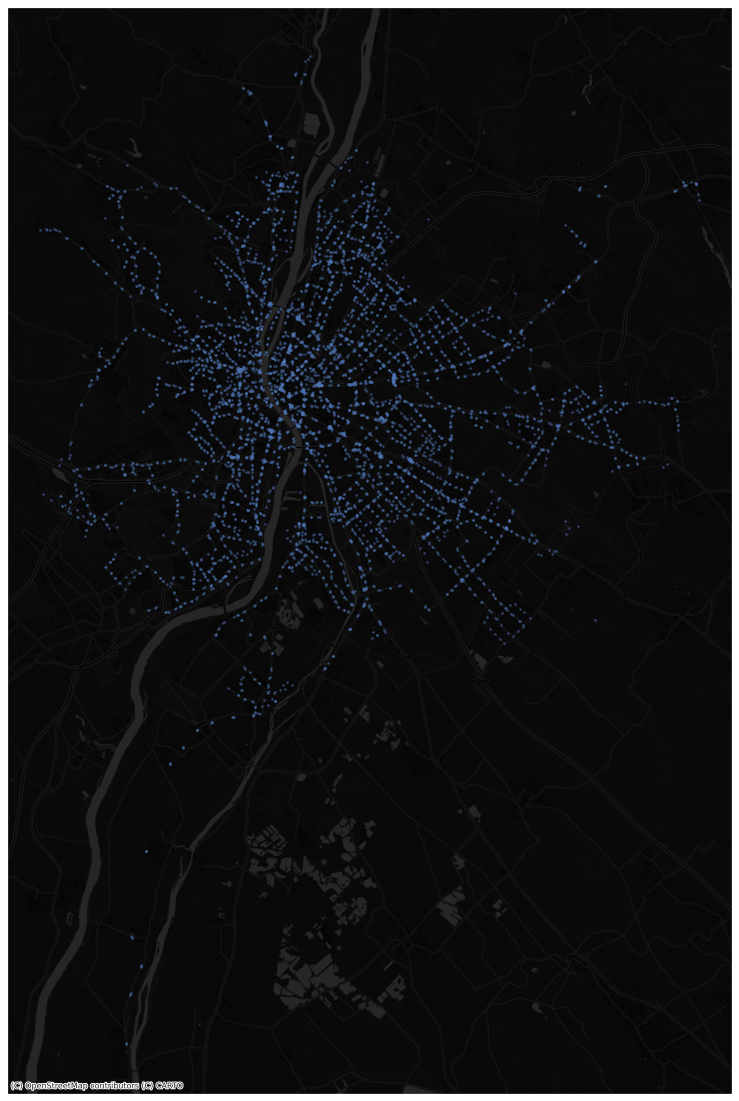

In [45]:
## Mapping all stops in the system

stops = stops.to_crs(epsg=3857)
ax = stops.plot(figsize=(20,20), alpha=0.4, markersize=3)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.CartoDB.DarkMatterNoLabels)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

In [46]:
#stops.to_file("./output/stops.geojson", driver="GeoJSON")

#### 5.1.3 Visualise a daily changes of the public transport traffic 

In [47]:
gpd_stop_times = pd.merge(stop_times, stops, on="stop_id", how="left")

In [48]:
gpd_stop_times = gpd.GeoDataFrame(gpd_stop_times, geometry=gpd_stop_times.geometry)

In [49]:
gpd_stop_times = gpd_stop_times[['stop_id','arrival_time', 'date', 'weekend','geometry', 'stop_lat','stop_lon']]

In [50]:
def generateBaseMap(default_location=[47.488, 19.05408], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start, tiles='cartodbdark_matter')
    return base_map

In [51]:
weekday = gpd_stop_times[~gpd_stop_times.weekend]
weekday_list = weekday[['stop_lat', 'stop_lon','stop_id']].groupby(['stop_lat', 'stop_lon']).count()
#busy_day_list.loc[:,'stop_id'] = busy_day_list.stop_id / busy_day_list.stop_id.max() * 10

In [52]:
weekday_list.loc[:,'stop_id'] = minmax.fit_transform(weekday_list) * 10

In [53]:
base_map = generateBaseMap()
HeatMap(data=weekday_list.reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

In [54]:
# Visualise stops activity of the busiest day - separate hourly

In [55]:
weekday = weekday.dropna(subset=['arrival_time'])

In [56]:
weekday['hour'] = weekday.arrival_time.dt.hour

In [57]:
df_hour_list = []
for hour in weekday.hour.sort_values().unique():
    weekday_list = weekday.loc[weekday.hour == hour, ['stop_lat', 'stop_lon', 'stop_id']].groupby(['stop_lat', 'stop_lon']).count()
    weekday_list.loc[:,'stop_id'] = minmax.fit_transform(weekday_list) * 10
    
    df_hour_list.append(weekday_list.reset_index().values.tolist())


In [58]:
base_map = generateBaseMap()
HeatMapWithTime(df_hour_list, radius=7, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map.save('byHour.html')

In [59]:
### 10 Min

In [60]:
weekday['min10'] =  weekday.arrival_time.dt.hour * 60 +  weekday.arrival_time.dt.minute

In [61]:
weekday['min10'] = np.floor(weekday['min10']/10)

In [62]:
weekday['min10'].value_counts()
#ax = sns.countplot(x="min10", data=gdf_shapes)

43.0    10215
44.0    10141
45.0    10104
42.0    10049
46.0    10036
        ...  
11.0      674
12.0      666
10.0      652
16.0      622
13.0      621
Name: min10, Length: 144, dtype: int64

In [63]:
df_10min_list = []
for mins in weekday.min10.sort_values().unique():
    weekday_list = weekday.loc[weekday.min10 == mins, ['stop_lat', 'stop_lon', 'stop_id']].groupby(['stop_lat', 'stop_lon']).count()
    weekday_list.loc[:,'stop_id'] = minmax.fit_transform(weekday_list) * 10
    df_10min_list.append(weekday_list.reset_index().values.tolist())

In [64]:
base_map = generateBaseMap()
HeatMapWithTime(df_10min_list , radius=4, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.6, max_opacity=0.9, use_local_extrema=True).add_to(base_map)

base_map.save('By10min.html')

### 5.2 Bus Route Clustering

### 5.2.1 Bus Route Clustering - weekdays

In [65]:
### Filter to Bus
shape_stats_bus =gdf_shapes_week[gdf_shapes_week.route_type=="Bus"]

In [66]:
## Drop data error - line starting with M are metro lines and starting with H are overground
shape_stats_bus = shape_stats_bus[~shape_stats_bus['route_short_name'].str.contains(r"^H|^M")]

#### 5.2.1.1 Standardise

<AxesSubplot:ylabel='Frequency'>

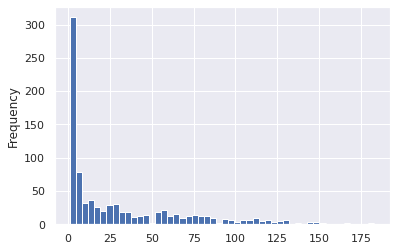

In [67]:
shape_stats_bus.count_trips.plot.hist(bins=50)

In [68]:
normed = shape_stats_bus.copy()

In [69]:
normed[['count_trips', 'count_stops', 'speed']] = rs.fit_transform(normed[['count_trips', 'stop_density', 'speed']])

In [70]:
normed = normed[['count_trips', 'stop_density', 'speed']]

#### 5.2.1.2 Elbow method - select the number of clusters

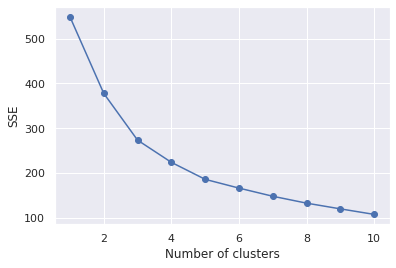

In [71]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [72]:
k_cluster = 4
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=4, random_state=1)

In [73]:
shape_stats_bus['KC cluster'] = kmeans_method.labels_

In [74]:
## Assign color to the clusters

colors = sns.color_palette("Set2")
shape_stats_bus['color'] =  shape_stats_bus['KC cluster'].apply(lambda x : colors[x])

### ...TEXT About Clusters

Weekday:

The following couple of figures will explore the four identified clusters in the bus routes.

-	Cluster 0: the group of routes with the lowest average speed and the highest stop density represents the bus routes for reaching/connecting more habitants of the city rather than providing quick commuting solutions. The map below shows that this cluster covering most of the city with a high density in Inner Budapest and certain north suburb area. 
-	Cluster 1: the category the contains the most frequent bus schedules (count_trips) with 95.7 average trips per day. It transits slightly faster and has fewer stops on average than Cluster 0. Cluster 1 consist the essential bus routes for the city’s population crossing the Danube bridges regularly connecting the two part of the city Buda and Pest.  
-	Cluster 2: this group has the higher speed, occasional buses with only 9.7 trips per day. A lot of these routes are the nigh bus routes, they cover most of the main squares and streets of the city with low stop density and higher speed with the lack of traffic at night.
-	Cluster 3: This is the cluster of fast buses with the aim of take long distance with higher speed which requires low stop density. These routes are helping commuters to get to the city centre from the suburbs and also contains the bus 200E which connects the city with the international airport.


In [75]:
shape_stats_bus.groupby('KC cluster').agg({'geometry' : 'count','speed' : 'mean', 'count_trips' : 'mean',  'stop_density' : 'mean'})

geometry      speed  count_trips  stop_density
KC cluster                                                
0                176  20.147586    27.710227      2.654463
1                147  21.591181    95.714286      2.153658
2                394  26.389924     9.725888      2.074076
3                145  28.606226    26.579310      1.220084

In [76]:
## Distribution of observed varaibles across the identified clusters

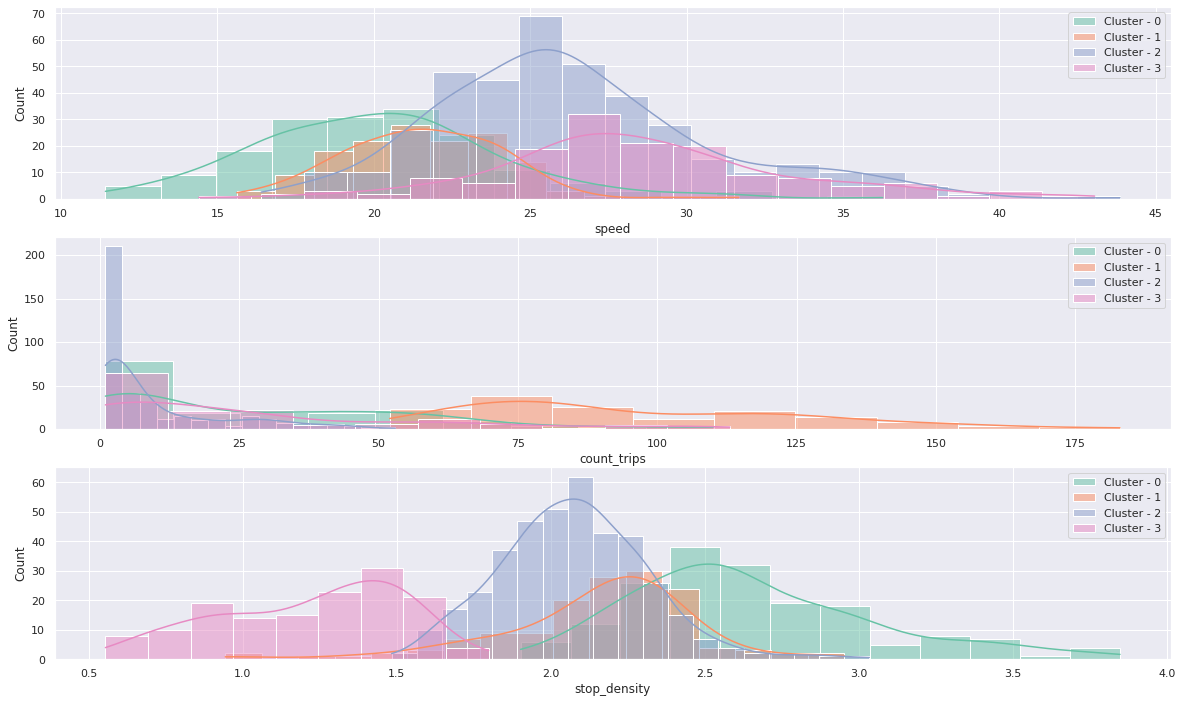

In [77]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))
for i, a in enumerate(['speed', 'count_trips', 'stop_density']):
    sns.histplot(ax=ax[i], label="Cluster - 0", data=shape_stats_bus[shape_stats_bus['KC cluster']==0], x=a, color=colors[0], kde=True)
    sns.histplot( ax=ax[i],label="Cluster - 1", data=shape_stats_bus[shape_stats_bus['KC cluster']==1], x=a, color=colors[1], kde=True)
    sns.histplot(ax=ax[i],label="Cluster - 2", data=shape_stats_bus[shape_stats_bus['KC cluster']==2], x=a, color=colors[2], kde=True)
    sns.histplot( ax=ax[i],label="Cluster - 3", data=shape_stats_bus[shape_stats_bus['KC cluster']==3], x=a, color=colors[3], kde=True)
   # ax[i].title.set_text(f"{a}")

    ax[i].legend()

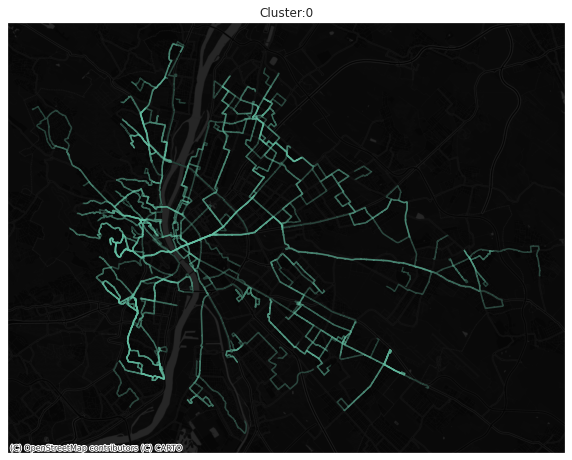

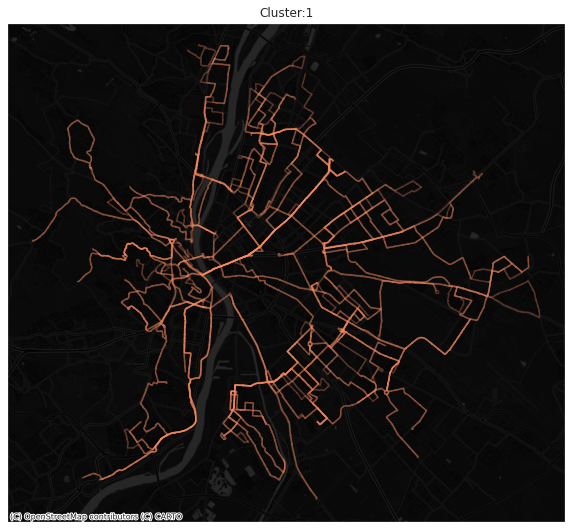

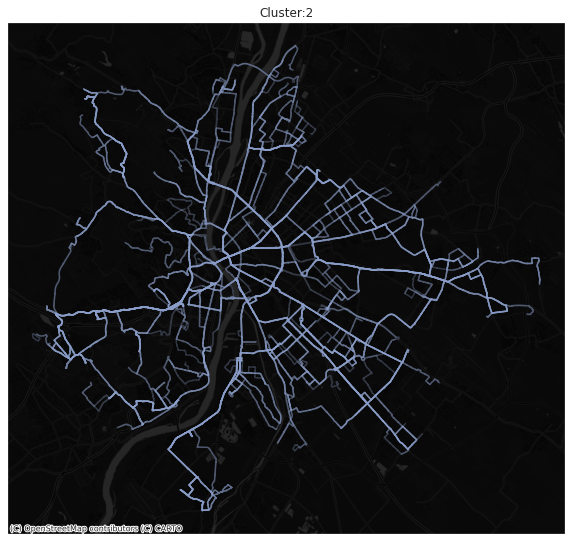

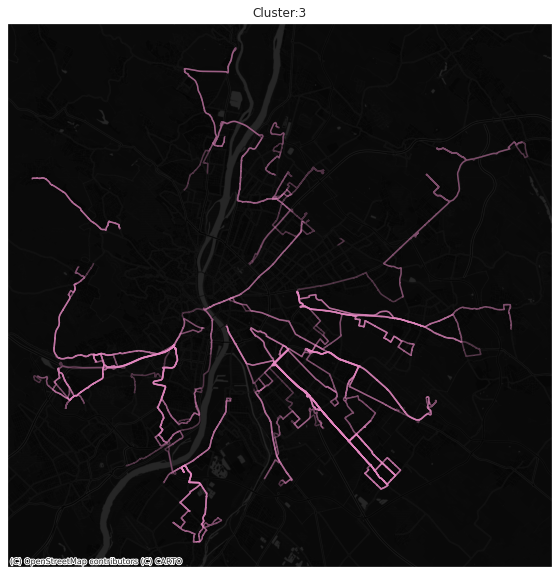

In [78]:
### Distribution visu with histograms
for n in range(4):
    ax = shape_stats_bus[shape_stats_bus['KC cluster']==n].plot( figsize=(10,10), alpha=0.3, color=sns.color_palette("Set2")[n])
    ctx.add_basemap(ax, zoom=12, source=ctx.providers.CartoDB.DarkMatterNoLabels)
    ax.set_title( 'Cluster:'  + str(n))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

In [79]:
###Plotting all on one map!

Text(0.5, 1.0, 'All clusters - Weekend')

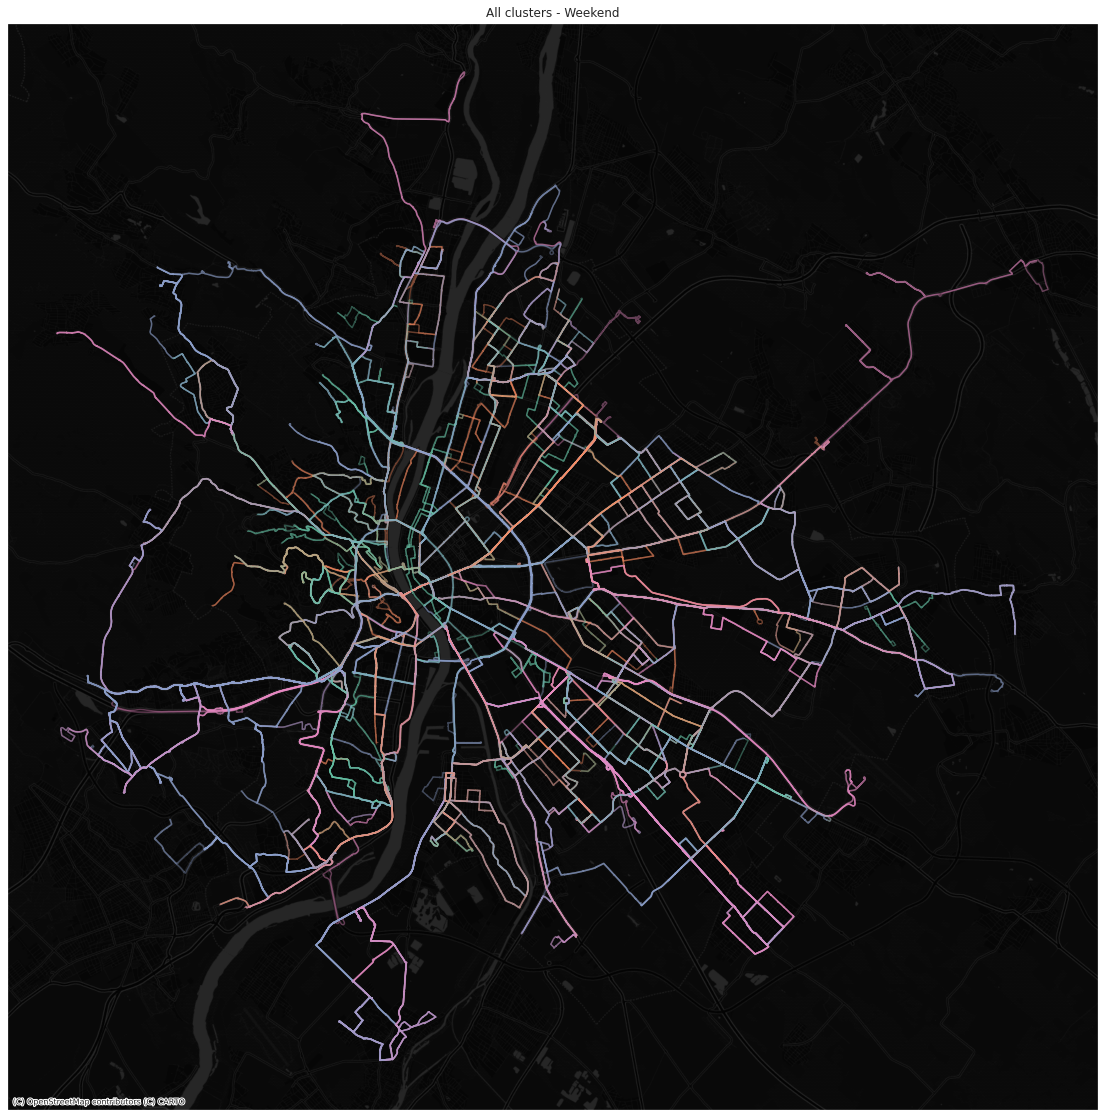

In [80]:
shape_stats_bus = shape_stats_bus.to_crs(epsg=3857)
ax = shape_stats_bus.plot(figsize=(20, 20), alpha=0.4, color=shape_stats_bus.color)
#gdf_shapes[gdf_shapes['shape_id']=="SW00"].plot(alpha=1,  color='blue', ax=ax)
#gdf_shapes[gdf_shapes['shape_id']=="X485"].plot(alpha=1,  color='green', ax=ax)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.CartoDB.DarkMatterNoLabels)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title( 'All clusters - Weekend')


In [81]:
shape_stats_bus.to_csv('./output/bus_shape_week_stats.csv')

### Weekend clustering

In [82]:
### Filter to Bus
shape_stats_bus =gdf_shapes_weekend[gdf_shapes_weekend.route_type=="Bus"]

In [83]:
## Drop data error - line starting with M are metro lines and starting with H are overground
shape_stats_bus = shape_stats_bus[~shape_stats_bus['route_short_name'].str.contains(r"^H|^M")]

#### Standardise

<AxesSubplot:ylabel='Frequency'>

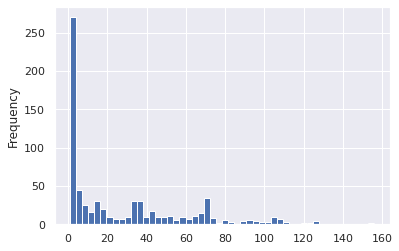

In [84]:
shape_stats_bus.count_trips.plot.hist(bins=50)

In [85]:
normed = shape_stats_bus.copy()

In [86]:
normed[['count_trips', 'count_stops', 'speed']] = rs.fit_transform(normed[['count_trips', 'stop_density', 'speed']])

In [87]:
normed = normed[['count_trips', 'stop_density', 'speed']]

## Kmeans

#### Elbow method

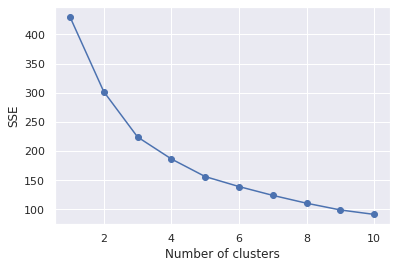

In [88]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [89]:
k_cluster = 4
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=4, random_state=1)

In [90]:
shape_stats_bus['KC cluster'] = kmeans_method.labels_

#### .... TEXT

In [91]:
colors = sns.color_palette("husl")
shape_stats_bus['color'] =  shape_stats_bus['KC cluster'].apply(lambda x : colors[x])

In [92]:
shape_stats_bus.groupby('KC cluster').agg({'geometry' : 'count','speed' : 'mean', 'count_trips' : 'mean',  'stop_density' : 'mean'})

geometry      speed  count_trips  stop_density
KC cluster                                                
0                135  23.033103    82.933333      2.198362
1                263  28.319963     8.486692      2.063462
2                234  21.518486    19.213675      2.486812
3                 78  30.839553    28.666667      1.310072

In [93]:
## Distribution of observed varaibles across the identified clusters

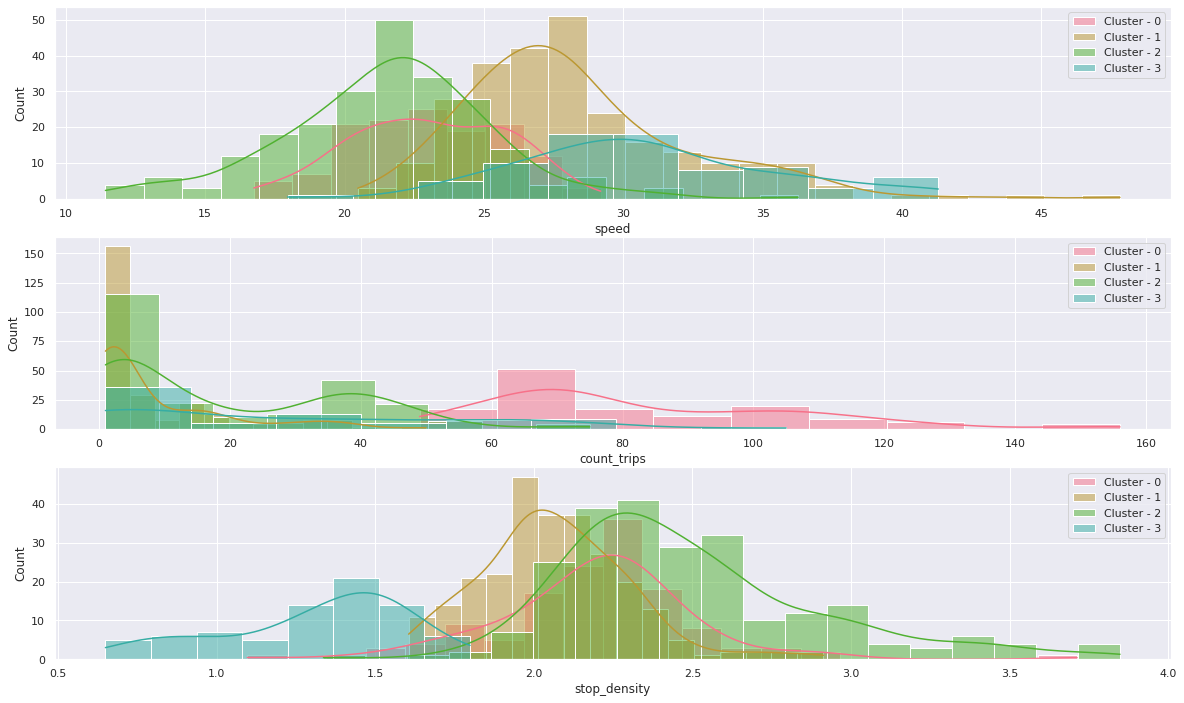

In [101]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))
for i, a in enumerate(['speed', 'count_trips', 'stop_density']):
    sns.histplot(ax=ax[i], label="Cluster - 0", data=shape_stats_bus[shape_stats_bus['KC cluster']==0], x=a, color=colors[0], kde=True)
    sns.histplot( ax=ax[i],label="Cluster - 1", data=shape_stats_bus[shape_stats_bus['KC cluster']==1], x=a, color=colors[1], kde=True)
    sns.histplot(ax=ax[i],label="Cluster - 2", data=shape_stats_bus[shape_stats_bus['KC cluster']==2], x=a, color=colors[2], kde=True)
    sns.histplot( ax=ax[i],label="Cluster - 3", data=shape_stats_bus[shape_stats_bus['KC cluster']==3], x=a, color=colors[3], kde=True)
   # ax[i].title.set_text(f"{a}")

    ax[i].legend()

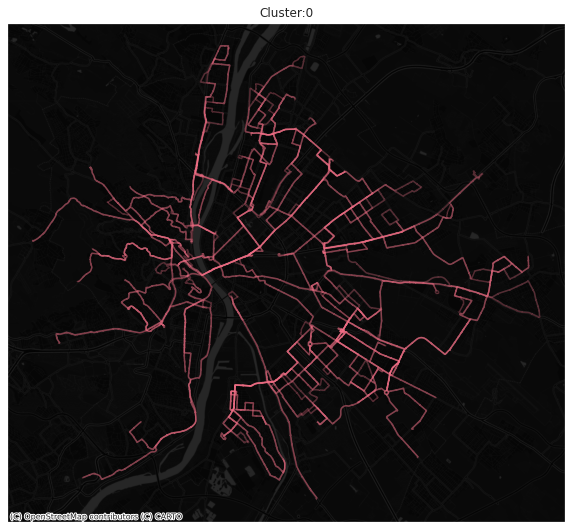

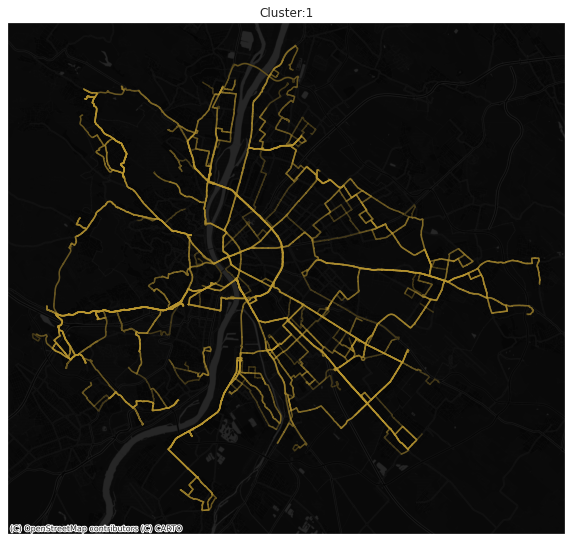

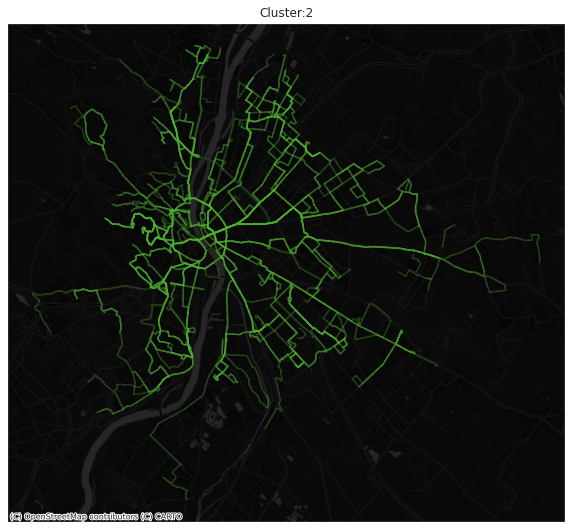

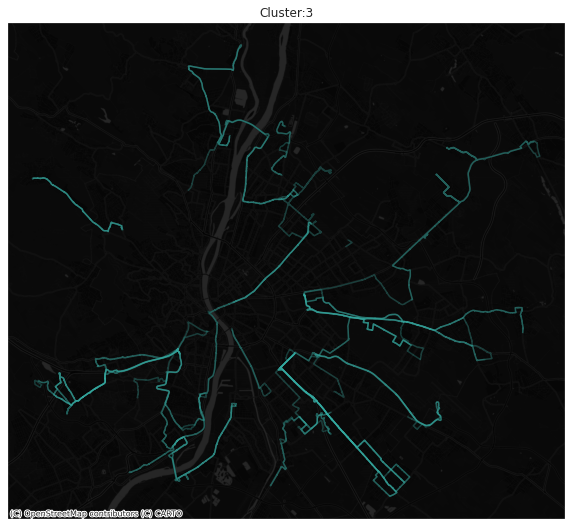

In [95]:
### Distribution visu with histograms
for n in range(4):
    ax = shape_stats_bus[shape_stats_bus['KC cluster']==n].plot( figsize=(10,10), alpha=0.3, color=colors[n])
    ctx.add_basemap(ax, zoom=12, source=ctx.providers.CartoDB.DarkMatterNoLabels)
    ax.set_title( 'Cluster:'  + str(n))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

In [96]:
###Plotting all on one map!

[]

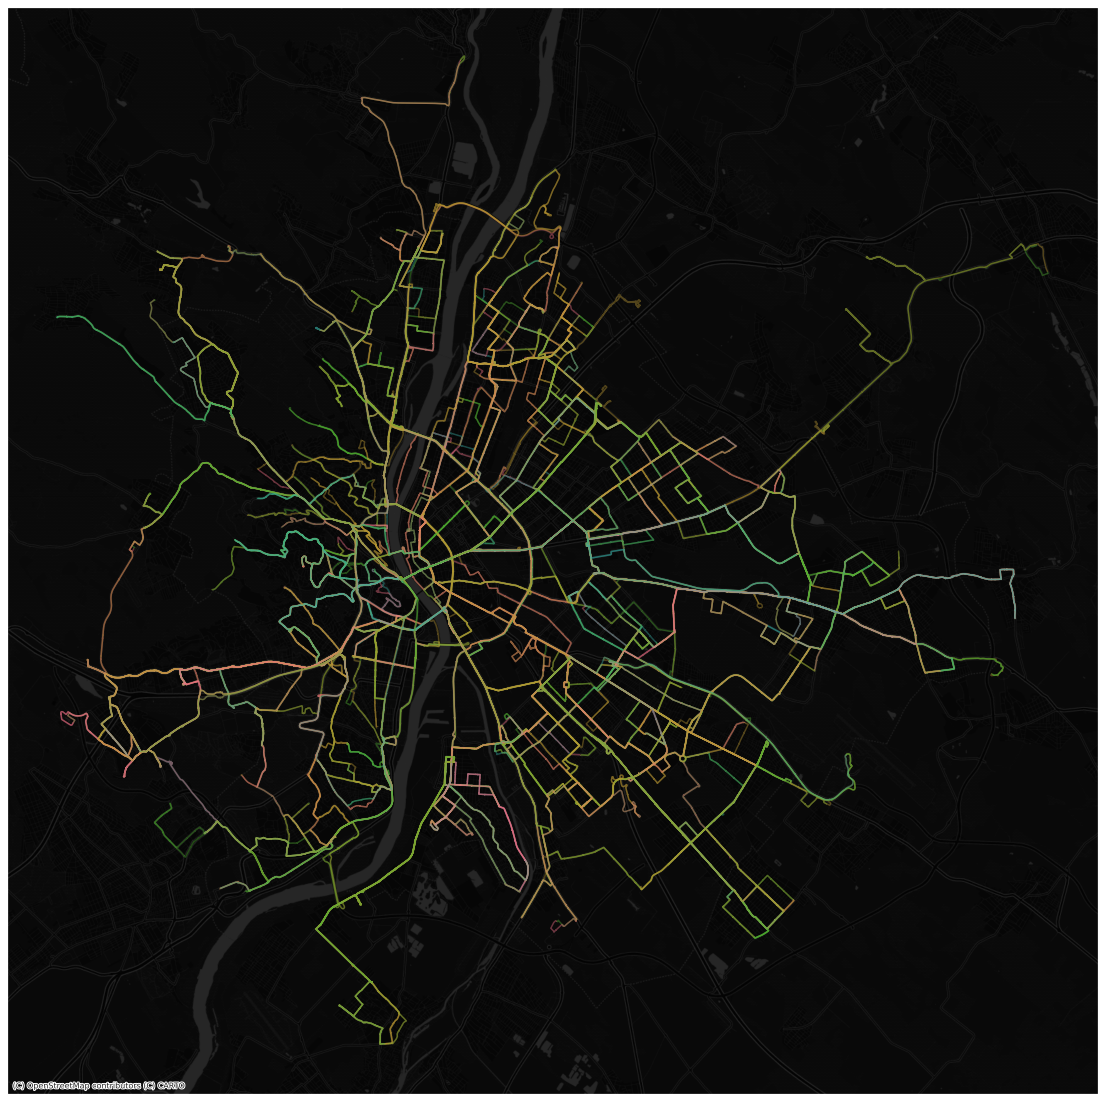

In [97]:
shape_stats_bus = shape_stats_bus.to_crs(epsg=3857)
ax = shape_stats_bus.sort_values('KC cluster').plot(figsize=(20, 20), alpha=0.4, color=shape_stats_bus.color)

#gdf_shapes[gdf_shapes['shape_id']=="SW00"].plot(alpha=1,  color='blue', ax=ax)
#gdf_shapes[gdf_shapes['shape_id']=="X485"].plot(alpha=1,  color='green', ax=ax)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.CartoDB.DarkMatterNoLabels)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# 6. Discussion and Conslusion